<div style="text-align:left;">
  <a href="https://code213.tech/" target="_blank">
    <img src="../images/code213.PNG" alt="QWorld">
  </a>
  <p><em>prepared by Latreche Sara</em></p>
</div>

# Gaussian Mixture Models (GMM)

Gaussian Mixture Models (GMMs) are a probabilistic model for representing the presence of subpopulations within an overall population, even without labeling. They are especially useful for clustering when the data comes from different Gaussian distributions.

## Intuition

GMM assumes that all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

Think of it like this: you have a bowl of mixed candies from different brands (but unlabeled). GMM tries to guess which candy came from which brand based on their shapes, sizes, and flavors (features), assuming each brand's candies are normally distributed.

## Mathematical Formulation

A Gaussian Mixture Model with $K$ components is defined as a weighted sum of $K$ Gaussian distributions:

$$
p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$

Where:
- $x$ is a $D$-dimensional data vector
- $\pi_k$ are the mixing coefficients such that $\sum_{k=1}^K \pi_k = 1$ and $0 \leq \pi_k \leq 1$
- $\mathcal{N}(x \mid \mu_k, \Sigma_k)$ is the multivariate Gaussian distribution:

$$
\mathcal{N}(x \mid \mu, \Sigma) = \frac{1}{(2\pi)^{D/2} |\Sigma|^{1/2}} \exp\left( -\frac{1}{2}(x-\mu)^\top \Sigma^{-1}(x-\mu) \right)
$$

### Expectation-Maximization (EM) Algorithm

EM is used to find maximum likelihood estimates of parameters in GMM.

1. **Initialize** parameters $\pi_k$, $\mu_k$, and $\Sigma_k$
2. **E-step**: Compute responsibilities:

$$
\gamma(z_{nk}) = \frac{\pi_k \mathcal{N}(x_n \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n \mid \mu_j, \Sigma_j)}
$$

3. **M-step**: Update the parameters:

$$
N_k = \sum_{n=1}^{N} \gamma(z_{nk})
$$

$$
\mu_k = \frac{1}{N_k} \sum_{n=1}^{N} \gamma(z_{nk}) x_n
$$

$$
\Sigma_k = \frac{1}{N_k} \sum_{n=1}^{N} \gamma(z_{nk})(x_n - \mu_k)(x_n - \mu_k)^\top
$$

$$
\pi_k = \frac{N_k}{N}
$$

4. Repeat until convergence.

In [31]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import make_blobs
import numpy as np


In [4]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [7]:
from sklearn.mixture import GaussianMixture

In [9]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [11]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [35]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [36]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

Did the algorithm actually converge?

In [13]:
gm.converged_

True

In [15]:
gm.n_iter_

4

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use predict() method or the predict_proba() method:

In [17]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1], dtype=int64)

In [19]:
gm.predict_proba(X)

array([[6.76282339e-07, 2.31833274e-02, 9.76815996e-01],
       [6.74575575e-04, 1.64110061e-02, 9.82914418e-01],
       [9.99922764e-01, 1.99781831e-06, 7.52377580e-05],
       ...,
       [2.12540639e-26, 9.99999568e-01, 4.31902443e-07],
       [1.45002917e-41, 1.00000000e+00, 5.20915318e-16],
       [7.93266114e-41, 1.00000000e+00, 2.30971331e-15]])

This is a generative model, so you can sample new instances from it (and get their labels):

In [21]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [42]:
y_new

array([0, 0, 1, 1, 1, 2])

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method:

In [23]:
gm.score_samples(X)

array([-2.60786904, -3.57094519, -3.3302143 , ..., -3.51359636,
       -4.39793229, -3.80725953])

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [25]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999225089

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [33]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

NameError: name 'plot_centroids' is not defined

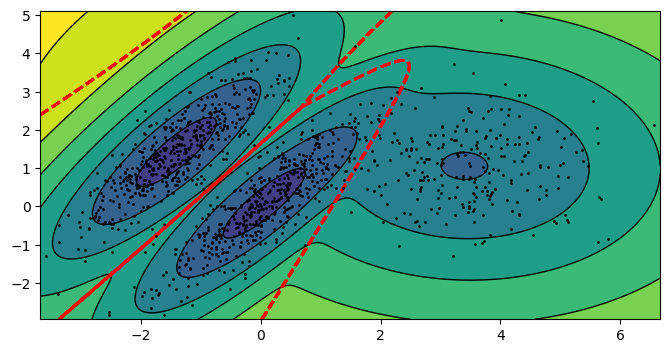

In [35]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

## Conclusion

GMM provides a flexible approach to clustering with soft assignments, capturing ellipsoidal clusters and overlapping data points. It is an improvement over k-means when clusters have different shapes or densities.